## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re 
import pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split

##### Reading the Treebank Tagged Sentences:

In [2]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
nltk_data[:20]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

##### Train Test Split:

In [4]:
train_set, test_set = train_test_split(nltk_data, train_size=0.95, test_size=0.05, random_state = 1234)

print("Length of Training Set: {}".format(len(train_set)))
print("Length of Test Set:".format(len(test_set)))
print("*"*50)
print("Training Data:\n")
print(train_set[:20])

Length of Training Set: 3718
Length of Test Set:
**************************************************
Training Data:

[[('This', 'DET'), ('year', 'NOUN'), (',', '.'), ('the', 'DET'), ('average', 'NOUN'), ('of', 'ADP'), ('daily', 'ADJ'), ('contracts', 'NOUN'), ('traded', 'VERB'), ('*', 'X'), ('totaled', 'VERB'), ('9,118', 'NUM'), (',', '.'), ('up', 'ADP'), ('from', 'ADP'), ('4,645', 'NUM'), ('a', 'DET'), ('year', 'NOUN'), ('earlier', 'ADJ'), ('and', 'CONJ'), ('from', 'ADP'), ('917', 'NUM'), ('in', 'ADP'), ('1984', 'NUM'), ('.', '.')], [('First', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-1', 'X'), ('now', 'ADV'), ('has', 'VERB'), ('45', 'NUM'), ('banks', 'NOUN'), ('and', 'CONJ'), ('$', '.'), ('12.5', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('assets', 'NOUN'), (',', '.'), ('announced', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('the', 'DET'), ('Peoria', 'NOUN'), (',', '.'), ('Ill.', 

##### Finding the list of train and test tagged words:

In [5]:
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Train Tagged Words Length: {}".format(len(train_tagged_words)))

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Test Tagged Words Length: {}".format(len(test_tagged_words)))

Train Tagged Words Length: 95799
Test Tagged Words Length: 4877


In [6]:
train_tagged_words[:10]

[('This', 'DET'),
 ('year', 'NOUN'),
 (',', '.'),
 ('the', 'DET'),
 ('average', 'NOUN'),
 ('of', 'ADP'),
 ('daily', 'ADJ'),
 ('contracts', 'NOUN'),
 ('traded', 'VERB'),
 ('*', 'X')]

##### Finding `tokens` from the train tagged words:

In [7]:
train_tokens = [pair[0] for pair in train_tagged_words]
train_tokens[:10]

['This',
 'year',
 ',',
 'the',
 'average',
 'of',
 'daily',
 'contracts',
 'traded',
 '*']

##### Getting POS tags for the tokens in the train_tagged_words

In [8]:
train_pos_tokens = [tag[1] for tag in train_tagged_words]
train_pos_tokens[:10]

['DET', 'NOUN', '.', 'DET', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'VERB', 'X']

##### Getting Vocabulary:

In [9]:
V = set(train_tokens)
print("Number of words in Vocabulary: {}".format(len(V)))

Number of words in Vocabulary: 12073


##### Getting unique number of tags:

In [10]:
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'DET', 'VERB', 'ADV', 'NOUN', 'NUM', 'CONJ', 'PRT', 'X', 'ADP', 'ADJ', '.', 'PRON'}


### Build the vanilla Viterbi based POS tagger

##### Calculating the probability of a word given a tag, P(w|t) and storing the records in a matrix:

In [11]:
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [12]:
w_given_t.shape

(12, 12073)

##### Computing Emission Probability; i.e. Word given tag:

In [13]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

##### Computing Transition Probability; i.e. tag2(t2) given tag1 (t1):

In [14]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

##### Getting matrix of tags:

In [15]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[5.44201257e-03, 3.95452902e-02, 1.26980292e-02, 6.38650358e-01,
        2.23727170e-02, 4.83734417e-04, 2.41867208e-04, 4.61966395e-02,
        9.19095427e-03, 2.03652188e-01, 1.77772399e-02, 3.74894193e-03],
       [1.33617356e-01, 1.67622000e-01, 8.35011601e-02, 1.10844307e-01,
        2.26955842e-02, 5.57707204e-03, 3.12161110e-02, 2.17815652e-01,
        9.14020166e-02, 6.52207583e-02, 3.51665393e-02, 3.53214554e-02],
       [6.84796870e-02, 3.44364345e-01, 8.12581927e-02, 3.11271306e-02,
        3.14547829e-02, 6.88073412e-03, 1.47444298e-02, 2.32634339e-02,
        1.18610747e-01, 1.29750982e-01, 1.34665787e-01, 1.53997382e-02],
       [1.32503370e-02, 1.46336138e-01, 1.71817560e-02, 2.64897525e-01,
        9.53732990e-03, 4.22627516e-02, 4.39736433e-02, 2.92308256e-02,
        1.77023038e-01, 1.22310799e-02, 2.39306912e-01, 4.76866495e-03],
       [2.97265151e-03, 1.81331746e-02, 2.97265151e-03, 3.54637325e-01,
        1.84898928e-01, 1.33769326e-02, 2.70511303e-02, 2.10

##### Converting the above matrix to a DataFrame for better look:

In [16]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,DET,VERB,ADV,NOUN,NUM,CONJ,PRT,X,ADP,ADJ,.,PRON
DET,0.005442,0.039545,0.012698,0.638650,0.022373,0.000484,0.000242,0.046197,0.009191,0.203652,0.017777,0.003749
VERB,0.133617,0.167622,0.083501,0.110844,0.022696,0.005577,0.031216,0.217816,0.091402,0.065221,0.035167,0.035321
ADV,0.068480,0.344364,0.081258,0.031127,0.031455,0.006881,0.014744,0.023263,0.118611,0.129751,0.134666,0.015400
NOUN,0.013250,0.146336,0.017182,0.264898,0.009537,0.042263,0.043974,0.029231,0.177023,0.012231,0.239307,0.004769
NUM,0.002973,0.018133,0.002973,0.354637,0.184899,0.013377,0.027051,0.210464,0.035672,0.032402,0.115933,0.001486
CONJ,0.118470,0.158582,0.055970,0.348881,0.041511,0.000466,0.005131,0.008862,0.052705,0.118937,0.033116,0.057369
PRT,0.099674,0.402932,0.009772,0.247883,0.056678,0.002280,0.001954,0.014007,0.021173,0.084039,0.041694,0.017915
X,0.054114,0.204114,0.026108,0.062184,0.002690,0.010759,0.184652,0.074842,0.144937,0.016456,0.162816,0.056329
ADP,0.322893,0.008522,0.013849,0.322893,0.062001,0.000959,0.001491,0.035048,0.016512,0.105785,0.039842,0.070203
ADJ,0.004948,0.012205,0.004948,0.698499,0.021112,0.016658,0.010886,0.021442,0.077519,0.065314,0.065809,0.000660


We can see that above is a 12x12 matrix. We can get records of any tags in tabular form. Below are some examples for getting records of individual tags:

##### Getting records of tag `NOUN`:

In [17]:
tags_df.loc['NOUN', :]

DET     0.013250
VERB    0.146336
ADV     0.017182
NOUN    0.264898
NUM     0.009537
CONJ    0.042263
PRT     0.043974
X       0.029231
ADP     0.177023
ADJ     0.012231
.       0.239307
PRON    0.004769
Name: NOUN, dtype: float32

##### Getting records of tag ADJ:

In [18]:
tags_df.loc['ADJ', :]

DET     0.004948
VERB    0.012205
ADV     0.004948
NOUN    0.698499
NUM     0.021112
CONJ    0.016658
PRT     0.010886
X       0.021442
ADP     0.077519
ADJ     0.065314
.       0.065809
PRON    0.000660
Name: ADJ, dtype: float32

##### Visualizing the DataFrame using Heat Map:

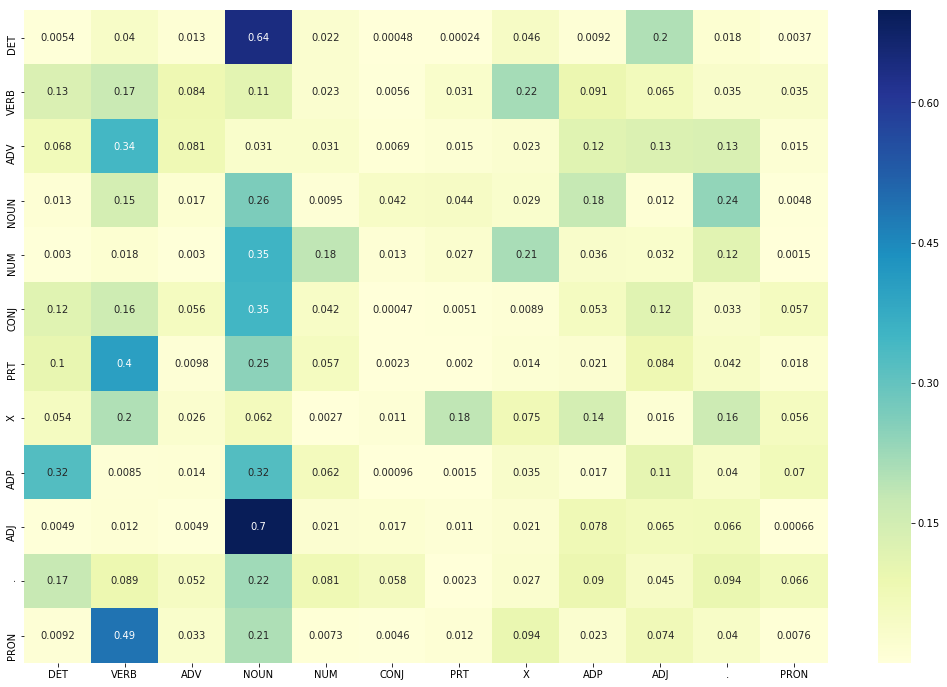

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot=True, cmap='YlGnBu')
plt.show()

From the above graph, we can see that highest probability is between the tags `ADJ` and `NOUN`.

##### Plotting the frequent tags whose probabilities are greater than 0.25; i.e. P(t2, t1) > 0.25:

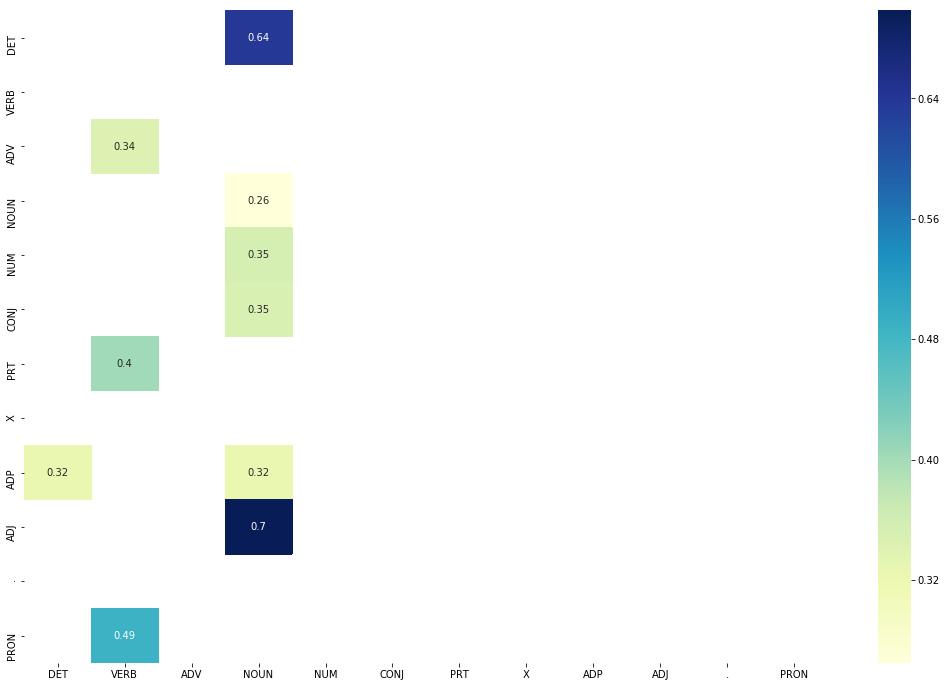

In [20]:
tags_frequent = tags_df[tags_df > 0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot=True, cmap='YlGnBu')
plt.show()

We can see from the above graphs that `ADJ` and `NOUN` tags are much frequent.

##### Now, applying Viterbi Algorithm using the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document:

### Viterbi Algorithm:

##### Vanilla Viterbi Algorithm:

In [21]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

##### Testing the Viterbi algorithm on a fewer sample sentences of test dataset:

In [22]:
random.seed(100)

# choose random 5 sents
rndom = [random.randint(1, len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

##### Tagging the test sentences:

In [23]:
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken (in seconds): {}".format(difference))

Time taken (in seconds): 21.875502347946167


##### Getting Accuracy:

In [24]:
vanilla_viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
vanilla_viterbi_accuracy = len(vanilla_viterbi_word_check)/len(tagged_seq) * 100
print('Vanilla Viterbi Original Accuracy: {}'.format(vanilla_viterbi_accuracy))

Vanilla Viterbi Original Accuracy: 86.95652173913044


##### Checking the incorrectly tagged words:

In [25]:
incorrect_tagged_words = [j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
print("Number of Incorrect Tagged Words: {}".format(len(incorrect_tagged_words)))
print("\n")
print("List of Incorrect Tagged Words:\n {}".format(incorrect_tagged_words))

Number of Incorrect Tagged Words: 15


List of Incorrect Tagged Words:
 [(('GOODY', 'DET'), ('GOODY', 'NOUN')), (('PRODUCTS', 'DET'), ('PRODUCTS', 'NOUN')), (('11.5', 'DET'), ('11.5', 'NUM')), (('500-Stock', 'DET'), ('500-Stock', 'NOUN')), (('0.84', 'DET'), ('0.84', 'NUM')), (('341.20', 'DET'), ('341.20', 'NUM')), (('equivalent', 'NOUN'), ('equivalent', 'ADJ')), (('average', 'ADJ'), ('average', 'NOUN')), (('minority-owned', 'DET'), ('minority-owned', 'ADJ')), (('blighted', 'DET'), ('blighted', 'ADJ')), (('famous', 'DET'), ('famous', 'ADJ')), (('Jimmy', 'DET'), ('Jimmy', 'NOUN')), (('promised', 'DET'), ('promised', 'VERB')), (('stiffer', 'DET'), ('stiffer', 'ADJ')), (('1', 'NUM'), ('1', 'X'))]


### Solve the problem of unknown words

### Viterbi Modification - Technique 1:
There are 2 kinds of probabilities: Transition and Emission. So, if we find that emission probability is 0; it means, the word is unknown. So, according to this case, we'll use only transition probabilty otherwise we'll use both emission and transition probabilities.

In [26]:
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # Now, modifying the original Vanilla Viterbi Algorithm to consider unknown words:
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

##### Tagging the test sentences:

In [27]:
start = time.time()
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
print("Time taken (in seconds): ", difference)

# accuracy
unknown_words = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

modified_viterbi_accuracy = len(unknown_words)/len(unknown_word_tagged_seq)

print("Vanilla Viterbi Modified Accuracy: {}".format(modified_viterbi_accuracy))

Time taken (in seconds):  21.875502347946167
Vanilla Viterbi Modified Accuracy: 0.8869565217391304


From the above result, we can see that our modified algorithm for unknown words is performing better. We have achieved 88.7% accuracy. Our next step is to try to overcome the loss at some extent.

#### First trying Lexicon and Rule-Based Methods for POS Tagging:

##### Lexicon (Unigram) Tagger:
Training a lexicon (or a unigram) tagger which assigns the most commonly assigned tag to a word

In [28]:
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy = unigram_tagger.evaluate(test_set)
print("Simple Unigram Accuracy: {}".format(unigram_accuracy))

Simple Unigram Accuracy: 0.9034242362107853


##### Now, combining the unigram tagger with a rule based regex tagger:

In [29]:
patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [30]:
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
unigram_regexp_tagger_accuracy = rule_based_unigram_tagger.evaluate(test_set)
print("Unigram Accuracy (Backed up RegexpTagger): {}".format(unigram_regexp_tagger_accuracy))

Unigram Accuracy (Backed up RegexpTagger): 0.9329505843756407


We can see from the above result that the accuracy of the Unigram Tagger backed up by the Regexp Tagger slightly improved.

##### Bigram Tagger:

In [31]:
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_accuracy = bigram_tagger.evaluate(test_set)
print("Bigram Accuracy (Backed up by the Rule Based Unigram Tagger): {}".format(bigram_accuracy))

Bigram Accuracy (Backed up by the Rule Based Unigram Tagger): 0.9388968628255074


##### Trigram Tagger:

In [32]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_accuracy = trigram_tagger.evaluate(test_set)
print("Trigram Accuracy (Backed up by the Bigram Tagger: {}".format(trigram_accuracy))

Trigram Accuracy (Backed up by the Bigram Tagger: 0.9384867746565512


From the above codes of Unigram, Bigram and Trigram, we notice that the Trigram Tagger backed up by the Bigram Tagger gives accuracy of about 93.8%. Let's use this result for further modification.

### Viterbi Modification-Technique 2:
We are going to modify the Viterbi Algorithm to have trigram tagger as a back-off. We are designing the algo in such a way that When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [33]:
# A trigram tagger backed off by a rule based tagger.
def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # Below is code fpr trigram tagger backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

##### Viterbi Algo backed up by trigram tagger:

In [34]:
def viterbi_backedup_by_trigram_tagger(words, train_bag = train_tagged_words):
    state = []
    tag_set = list(set([pair[1] for pair in train_bag]))
    
    # use the trigram tagger backed up by the rule based tagger
    # for unknown words.
    for key, word in enumerate(words):
        if word not in V:
            unknown_word_tag = trigram_tagger(word)
            for sent in unknown_word_tag:
                for tup in sent:
                    state.append(tup[1])
        else:            
            p = [] 
            for tag in tag_set:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = tag_set[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [35]:
# tagging the test sentences
start = time.time()
viterbi_trigram_tagged_sequence = viterbi_backedup_by_trigram_tagger(test_tagged_words)
end = time.time()
print("Time taken (in seconds): ", difference)

# accuracy
viterbi_trigram_words = [i for i, j in zip(viterbi_trigram_tagged_sequence, test_run_base) if i == j]

viterbi_trigram_accuracy = len(viterbi_trigram_words)/len(viterbi_trigram_tagged_sequence)

print("Vanilla Viterbi Modified Accuracy (Backed up By Trigram Tagger): {}".format(viterbi_trigram_accuracy))

Time taken (in seconds):  21.875502347946167
Vanilla Viterbi Modified Accuracy (Backed up By Trigram Tagger): 0.9391304347826087


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [36]:
acccuracy = [['Vanilla Viterbi Original', vanilla_viterbi_accuracy], 
                  ['Vanilla Viterbi Modified', modified_viterbi_accuracy * 100], 
                  ['Unigram Tagger', unigram_accuracy * 100],
                  ['Unigram + RegexpTagger', unigram_regexp_tagger_accuracy * 100],
                  ['Bigram Tagger + Unigram_Tagger', bigram_accuracy * 100],
                  ['Trigram Tagger + Bigram_tagger', trigram_accuracy * 100],
                  ['Viterbi + Trigram_Tagger', viterbi_trigram_accuracy * 100]]

acccuracy_df = pd.DataFrame(acccuracy, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_df.sort_values(by='Tagging_Accuracy', ascending= False)

,Tagging_Accuracy
Tagging_Algorithm,
Viterbi + Trigram_Tagger,93.913043
Bigram Tagger + Unigram_Tagger,93.889686
Trigram Tagger + Bigram_tagger,93.848677
Unigram + RegexpTagger,93.295058
Unigram Tagger,90.342424
Vanilla Viterbi Modified,88.695652
Vanilla Viterbi Original,86.956522


##### Importing the Sample Test Data File:

In [37]:
sample_test = pd.read_csv("Test_sentences.txt", sep= '\t', header=None)
sample_test.columns = ['Test_Samples']
sample_test

,Test_Samples
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


##### Taking the lines of sample test data into a list form:

In [38]:
sample_test_list = [x for x in sample_test['Test_Samples']]
sample_test_list

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

##### Tokenizing the sample test data and creating POS Tags for them:

In [39]:
sample_test_tokens = [word_tokenize(sent) for sent in sample_test_list]
sample_test_pos_tags = nltk.pos_tag_sents(sample_test_tokens, tagset = 'universal')
sample_test_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

##### Listing the untagged words from the sample test data:

In [40]:
sample_test_tagged_words = [tup[0] for sent in sample_test_pos_tags for tup in sent]
sample_test_word_tag = [tup for sent in sample_test_pos_tags for tup in sent]

In [41]:
sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

##### 1. Testing the accuracy of Vanilla Viterbi on sample test data:

In [42]:
# tagging the test sentences
sample_test_tagged_sequence = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_sequence, sample_test_word_tag) if i == j]

sample_test_vanilla_viterbi_accuracy = len(sample_test_check)/len(sample_test_tagged_sequence)

print("Vanilla Viterbi Sample Test Accuracy: {}".format(sample_test_vanilla_viterbi_accuracy))

Vanilla Viterbi Sample Test Accuracy: 0.7513812154696132


##### 2. Testing the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data - 

In [43]:
# tagging the test sentences
sample_test_unknown_word_tagged_sequence = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_words = [i for i, j in zip(sample_test_unknown_word_tagged_sequence, sample_test_word_tag) if i == j]

sample_test_modified_viterbi_accuracy = len(sample_test_unknown_words)/len(sample_test_unknown_word_tagged_sequence)

print("Vanilla Viterbi Sample Test Unknown Words Accuracy: {}".format(sample_test_modified_viterbi_accuracy))

Vanilla Viterbi Sample Test Unknown Words Accuracy: 0.861878453038674


##### 3. Testing the accuracy of viterbi_backedup_by_trigram_tagger on sample test data:

In [44]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_sequence = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_words = [i for i, j in zip(sample_test_viterbi_trigram_tagged_sequence, sample_test_word_tag) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_words)/len(sample_test_viterbi_trigram_tagged_sequence)

print("Vanilla Viterbi (Backedup by Trigram Tagger) Sample Test Accuracy: {}".format(sample_test_viterbi_trigram_accuracy))

Vanilla Viterbi (Backedup by Trigram Tagger) Sample Test Accuracy: 0.9281767955801105


##### Comparing the accuracies of the above 3 algorithm on sample test data:

In [45]:
sample_test_data_accuracy = [['Vanilla Viterbi', sample_test_vanilla_viterbi_accuracy * 100], 
                  ['Modified Vanilla Viterbi', sample_test_modified_viterbi_accuracy * 100], 
                  ['Viterbi + Trigram Tagger', sample_test_viterbi_trigram_accuracy * 100]]

sample_test_data_acccuracy_df = pd.DataFrame(sample_test_data_accuracy, columns = ['Tagging Method', 'Tagging Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging Method', drop = True, inplace = True)

sample_test_data_acccuracy_df = sample_test_data_acccuracy_df.sort_values(by='Tagging Accuracy', ascending=False)
sample_test_data_acccuracy_df

,Tagging Accuracy
Tagging Method,
Viterbi + Trigram Tagger,92.817680
Modified Vanilla Viterbi,86.187845
Vanilla Viterbi,75.138122


From the above result, we can see that the Viterbi Algo with Trigram Tagger works with ~93% accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications:

In [46]:
test_sentence_1 = sample_test['Test_Samples'][0]
test_sentence_2 = sample_test['Test_Samples'][1]
test_sentence_3 = sample_test['Test_Samples'][2]
test_sentence_4 = sample_test['Test_Samples'][3]
test_sentence_5 = sample_test['Test_Samples'][4]
test_sentence_6 = sample_test['Test_Samples'][5]
test_sentence_7 = sample_test['Test_Samples'][6]
test_sentence_8 = sample_test['Test_Samples'][7]
test_sentence_9 = sample_test['Test_Samples'][8]
test_sentence_10 = sample_test['Test_Samples'][9]
test_sentence_11 = sample_test['Test_Samples'][10]

### Case 1:

##### Let's try the first with first test sample sentence 'Android is a mobile operating system developed by Google.'

In [47]:
words_test_sentence_1 = nltk.word_tokenize(test_sentence_1)

# Vanilla_Viterbi POS Tags:
vanilla_viterbi_pos_tagged_sequence_1 = Vanilla_Viterbi(words_test_sentence_1)
print("Tagging sequence (Vanilla_Viterbi):\n\n{}".format(vanilla_viterbi_pos_tagged_sequence_1))

print('*' * 120)

# Viterbi_backedup_by_trigram_tagger POS Tags:
viterbi_trigram_pos_tagged_sequence_1 = viterbi_backedup_by_trigram_tagger(words_test_sentence_1)
print("\nTagging sequence (viterbi_backedup_by_trigram_tagger):\n\n{}".format(viterbi_trigram_pos_tagged_sequence_1))

Tagging sequence (Vanilla_Viterbi):

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
************************************************************************************************************************

Tagging sequence (viterbi_backedup_by_trigram_tagger):

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [48]:
correction_of_tags_1 = pd.DataFrame(columns = ['Vanilla_Viterbi_Tags', 'Corrected_Tags_With_Viterbi_Trigram'])
correction_of_tags_1 = correction_of_tags_1.fillna(0)

correction_of_tags_1['Vanilla_Viterbi_Tags'] = [tup for tup in vanilla_viterbi_pos_tagged_sequence_1]
correction_of_tags_1['Corrected_Tags_With_Viterbi_Trigram'] = [tup for tup in viterbi_trigram_pos_tagged_sequence_1]

correction_of_tags_1

,Vanilla_Viterbi_Tags,Corrected_Tags_With_Viterbi_Trigram
0,"(Android, DET)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)"
8,"(Google, DET)","(Google, NOUN)"
9,"(., .)","(., .)"


From the above table, we can see that Android and Google tagged which are wrongly tagged in Vanilla Viterbi, are now tagged with NOUN in Viterbi Tigram.

### Case 2:

##### Let's try the with 6th test sample sentence 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'

In [49]:
words_test_sentence_6 = nltk.word_tokenize(test_sentence_6)

# Vanilla_Viterbi POS Tags:
vanilla_viterbi_pos_tagged_sequence_6 = Vanilla_Viterbi(words_test_sentence_6)
print("Tagging sequence (Vanilla_Viterbi):\n\n{}".format(vanilla_viterbi_pos_tagged_sequence_6))

print('\n')
print('*' * 100)

# Viterbi_backedup_by_trigram_tagger POS Tags:
viterbi_trigram_pos_tagged_sequence_6 = viterbi_backedup_by_trigram_tagger(words_test_sentence_6)
print("\nTagging sequence (viterbi_backedup_by_trigram_tagger):\n\n{}".format(viterbi_trigram_pos_tagged_sequence_6))

Tagging sequence (Vanilla_Viterbi):

[('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


****************************************************************************************************

Tagging sequence (viterbi_backedup_by_trigram_tagger):

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [50]:
correction_of_tags_6 = pd.DataFrame(columns = ['Vanilla_Viterbi_Tags', 'Corrected_Tags_With_Viterbi_Trigram'])
correction_of_tags_6 = correction_of_tags_6.fillna(0)

correction_of_tags_6['Vanilla_Viterbi_Tags'] = [tup for tup in vanilla_viterbi_pos_tagged_sequence_6]
correction_of_tags_6['Corrected_Tags_With_Viterbi_Trigram'] = [tup for tup in viterbi_trigram_pos_tagged_sequence_6]

correction_of_tags_6

,Vanilla_Viterbi_Tags,Corrected_Tags_With_Viterbi_Trigram
0,"(The, DET)","(The, DET)"
1,"(2018, DET)","(2018, NUM)"
2,"(FIFA, DET)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)"
4,"(Cup, DET)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)"
7,"(21st, DET)","(21st, NUM)"
8,"(FIFA, DET)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)"


As per the above results, it is obseved that tags for words 2018, FIFA, Cup, 21st etc are correctly tagged with the algo viterbi backed up by the trigram tagger.

### Case 3:

##### Let's try the with 8th test sample sentence 'Show me the cheapest round trips from Dallas to Atlanta'.:

In [51]:
words_test_sentence_8 = nltk.word_tokenize(test_sentence_8)

# Vanilla_Viterbi POS Tags:
vanilla_viterbi_pos_tagged_sequence_8 = Vanilla_Viterbi(words_test_sentence_8)
print("Tagging sequence (Vanilla_Viterbi):\n\n{}".format(vanilla_viterbi_pos_tagged_sequence_8))

print('\n')
print('-'*120)

# Viterbi_backedup_by_trigram_tagger POS Tags:
viterbi_trigram_pos_tagged_sequence_8 = viterbi_backedup_by_trigram_tagger(words_test_sentence_8)
print("\nTagging sequence (viterbi_backedup_by_trigram_tagger):\n\n{}".format(viterbi_trigram_pos_tagged_sequence_8))

Tagging sequence (Vanilla_Viterbi):

[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'DET'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


------------------------------------------------------------------------------------------------------------------------

Tagging sequence (viterbi_backedup_by_trigram_tagger):

[('Show', 'NOUN'), ('me', 'PRON'), ('the', 'DET'), ('cheapest', 'ADJ'), ('round', 'NOUN'), ('trips', 'NOUN'), ('from', 'ADP'), ('Dallas', 'NOUN'), ('to', 'PRT'), ('Atlanta', 'NOUN')]


In [52]:
correction_of_tags_8 = pd.DataFrame(columns = ['Vanilla_Viterbi_Tags', 'Corrected_Tags_With_Viterbi_Trigram'])
correction_of_tags_8 = correction_of_tags_8.fillna(0)

correction_of_tags_8['Vanilla_Viterbi_Tags'] = [tup for tup in vanilla_viterbi_pos_tagged_sequence_8]
correction_of_tags_8['Corrected_Tags_With_Viterbi_Trigram'] = [tup for tup in viterbi_trigram_pos_tagged_sequence_8]

correction_of_tags_8

,Vanilla_Viterbi_Tags,Corrected_Tags_With_Viterbi_Trigram
0,"(Show, NOUN)","(Show, NOUN)"
1,"(me, PRON)","(me, PRON)"
2,"(the, DET)","(the, DET)"
3,"(cheapest, ADJ)","(cheapest, ADJ)"
4,"(round, NOUN)","(round, NOUN)"
5,"(trips, DET)","(trips, NOUN)"
6,"(from, ADP)","(from, ADP)"
7,"(Dallas, NOUN)","(Dallas, NOUN)"
8,"(to, PRT)","(to, PRT)"
9,"(Atlanta, NOUN)","(Atlanta, NOUN)"


It is observed from the above results taht the tag for word 'trips' has been corrected in viterbi trigram algo.

**Let's use this sample test data with both the techniques we used above.**
##### Technique 1: Used only the transition probability for unknown words.
##### Technique 2: used the viterbi algorithm and backed it up with the trigram tagger which was backed up by the rule based regex tagger.

In [53]:
# Vanilla_Viterbi POS Tags:
vanilla_viterbi_sample_test_tagged_sequence = Vanilla_Viterbi(sample_test_tagged_words)
print("Tagging sequence with Vanilla_Viterbi:\n\n{}".format(vanilla_viterbi_sample_test_tagged_sequence))

print('*' * 100)
print('Technique 1:')

# Technique 1 - pos tags with Vanilla_Viterbi_for_Unknown_Words
unknown_words_sample_test_tagged_sequence = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)
print("Tagging sequence with viterbi using only transition probability:\n\n{}".format(unknown_words_sample_test_tagged_sequence))

print('\n')
print('*' * 100)
print('Technique 2:')

# Technique 2 - pos tags with viterbi_backedup_by_trigram_tagger
viterbi_trigram_sample_test_tagged_sequence = viterbi_backedup_by_trigram_tagger(sample_test_tagged_words)
print("Tagging sequence with viterbi_backedup_by_trigram_tagger:\n\n{}".format(viterbi_trigram_sample_test_tagged_sequence))

Tagging sequence with Vanilla_Viterbi:

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on',

#####  Let's summarise all the results in a Dataframe where collumns show "Original Tags", "Vanilla Viterbi Tags", "Tags by Vanilla Viterbi for Unknown Words" and "Tags by Vanilla Viterbi Backed by Trigram Tagger".

In [54]:
tags_df = pd.DataFrame(columns = ['Original_Tags', 'Vanilla_Viterbi_Tags', 'Unknown_Words_Vanilla_Viterbi_Tags',
            'Vanilla_Viterbi_Tags_Backed_By_Trigram_Tagger'])
tags_df = tags_df.fillna(0)

# Original tags
tags_df['Original_Tags'] = [x for x in sample_test_word_tag]

# tags by vanilla viterbi
tags_df['Vanilla_Viterbi_Tags'] = [x for x in vanilla_viterbi_sample_test_tagged_sequence]

# tags by Vanilla_Viterbi_for_Unknown_Words - Technique - 1
tags_df['Unknown_Words_Vanilla_Viterbi_Tags'] = [x for x in unknown_words_sample_test_tagged_sequence]

# tags by viterbi_backedup_by_trigram_tagger - Technique - 2
tags_df['Vanilla_Viterbi_Tags_Backed_By_Trigram_Tagger'] = [x for x in viterbi_trigram_sample_test_tagged_sequence]

tags_df[tags_df['Vanilla_Viterbi_Tags'] != tags_df['Vanilla_Viterbi_Tags_Backed_By_Trigram_Tagger']]

,Original_Tags,Vanilla_Viterbi_Tags,Unknown_Words_Vanilla_Viterbi_Tags,Vanilla_Viterbi_Tags_Backed_By_Trigram_Tagger
0,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
8,"(Google, NOUN)","(Google, DET)","(Google, DET)","(Google, NOUN)"
10,"(Android, NOUN)","(Android, DET)","(Android, NOUN)","(Android, NOUN)"
15,"(OS, NOUN)","(OS, DET)","(OS, NOUN)","(OS, NOUN)"
16,"(worldwide, NOUN)","(worldwide, DET)","(worldwide, NOUN)","(worldwide, NOUN)"
18,"(smartphones, NOUN)","(smartphones, DET)","(smartphones, DET)","(smartphones, VERB)"
20,"(2011, NUM)","(2011, DET)","(2011, DET)","(2011, NUM)"
25,"(2013, NUM)","(2013, DET)","(2013, DET)","(2013, NUM)"
27,"(Google, NOUN)","(Google, DET)","(Google, NOUN)","(Google, NOUN)"
29,"(Twitter, NOUN)","(Twitter, DET)","(Twitter, NOUN)","(Twitter, NOUN)"


### Final Conclusion:

Vanilla Viterbi Algorithm produced many wrongly tagged words. Those words are smartly corrected by the Viterbi Algorithm Backed Up By The Trigram Tagger. 

Below 2 techniques we used in this assignment:<br>
<br>

**Technique 1:**
- As a first approach, we used only the transition probability for unknown words.
- This technique has improved the accuracy but still had some incorrect tags.
- To improve the accuracy further, we have used a 2nd technique.
    
**Technique 2:** 
- As a second approach, we used the Viterbi Algorithm and Backed it up with the Trigram tagger which was backed up by the rule based 
    regex tagger.
- This gave us an accuracy of ~94% on the test data.
- Tested this model with the provided sample test data and found the accuracy around ~93%.
- So, it is recommended to use this algo for better results.